In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import dateutil
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib import pyplot as plt
from collections import deque
from creme import preprocessing

from offline_ts import SARMAPrediction
from online_ts import SARMA_OGD
from utils import mape, rmse

In [2]:
def create_date_col(row):
    """
    Tạo cột `date` cho dữ liệu load
    """
    date = dateutil.parser.parse(str(row['Timestamp'])).strftime('%m-%d-%Y')
    hour = str(row['Gio'])[1:].zfill(2)
    _datetime = f'{date} {hour}:00:00'
    return _datetime

def interpolate_nan_and_outlier(df, column):
    """
    Nội suy các dữ liệu thiếu và dữ liệu bất thường của cột trong dataframe
    """
    _df = df.copy()
    
    q75, q25 = np.nanpercentile(_df[column], [75, 25])
    iqr = q75 - q25
    
    _df[(_df[column] < q25 - 1.5 * iqr) | (_df[column] > q75 + 1.5 * iqr)] = np.nan # set nan for outliers
    _df[column] = _df[column].interpolate() # interpolate nan values
    return _df

def preprocess_load(df_load):
    hour_cols = [col for col in df_load.columns if col not in ['Timestamp']]
    df_load = pd.melt(df_load, id_vars=['Timestamp'], value_vars=hour_cols, var_name='Gio', value_name='Load')
    df_load['Date'] = df_load.apply(create_date_col, axis=1)
    df_load = df_load[['Date', 'Load']].copy()
    df_load['Date']= pd.to_datetime(df_load['Date'])
    df_load = df_load.sort_values(by='Date', ignore_index=True)
    df_load.set_index('Date', inplace=True)

    df_load = interpolate_nan_and_outlier(df_load, column='Load')
    df_load = df_load.resample('1H').mean().interpolate()
    return df_load

In [3]:
df = pd.read_csv('../data/Load_2021.csv')
df

,Timestamp,H0,H1,H2,H3,H4,H5,H6,H7,H8,...,H14,H15,H16,H17,H18,H19,H20,H21,H22,H23
0,2021-01-01,20243.630,19711.938,19599.077,19543.491,19649.902,19562.062,20674.950,20526.443,20284.050,...,20181.676,22061.078,23737.510,26174.624,23507.554,22554.414,21571.366,20132.398,18465.876,17423.869
1,2021-01-02,17041.711,16800.135,16697.893,17164.117,17999.727,19434.656,21993.124,24297.237,25000.379,...,26403.480,27799.891,28488.223,30149.097,27228.698,25834.388,25141.555,23506.907,21796.700,20893.608
2,2021-01-03,20266.189,20090.687,19820.371,20094.355,20373.084,21037.125,22985.614,24192.259,24310.685,...,26203.564,27594.005,29517.735,31310.413,28416.422,26872.442,25984.140,24262.565,22223.067,21322.247
3,2021-01-04,20858.764,20597.924,20583.662,20798.644,21738.629,23843.244,26607.812,29703.703,30534.599,...,32475.031,33331.266,34946.045,35641.907,32870.473,31328.736,29878.110,27653.494,26071.868,24046.635
4,2021-01-05,23343.600,23174.273,23106.104,23219.319,23865.169,25711.084,27646.402,30856.196,31759.866,...,33014.686,34074.221,34536.496,36090.126,32891.616,31394.150,30253.182,27864.918,26272.747,24356.223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,2021-07-25,25414.440,24817.157,24131.759,23283.664,22677.520,22960.183,23260.886,24576.534,25525.725,...,27403.591,27846.502,27918.395,27654.350,28943.408,28242.935,27987.994,27511.301,26253.363,24840.883
206,2021-07-26,23735.566,22965.483,22496.500,22234.203,22259.857,23073.074,24865.375,28526.500,29632.191,...,33184.182,33513.284,31637.165,30440.997,31475.200,30924.099,31651.716,31258.783,29958.149,28129.299
207,2021-07-27,26812.621,26129.896,25405.953,24946.596,24881.437,25056.640,26396.284,30048.189,31386.613,...,34277.984,33245.887,31298.494,30357.966,31020.300,31069.757,32454.866,32458.983,31264.286,29595.916
208,2021-07-28,27987.387,27000.145,26229.478,25674.810,24896.552,25130.234,26453.205,29885.818,31215.771,...,34154.007,33472.057,30919.537,30130.296,30325.586,30064.987,30937.823,30546.947,29541.874,27933.646


In [4]:
df = preprocess_load(df)
actual = df['Load'][-696:]

p = 2
P = 2
s = 24

## Offline Seasonal ARMA

In [5]:
def offline_forecast(series, p, P, q, Q, s):
    series_ = series.copy()
    series_ = np.log(series_)
    mean = series_.mean()
    std = series_.std()
    series_ = (series_ - mean) / std
    model = SARIMAX(series_, order=(p, 0, q), seasonal_order=(P, 0, Q, s), 
                    enforce_stationarity=False, enforce_invertibility=False)
    model_results = model.fit()
    
    predictor = SARMAPrediction(phi=model_results.params[:p],
                                Phi=model_results.params[p+q:p+q+P],
                                theta=model_results.params[p:p+q],
                                Theta=model_results.params[p+q+P:p+q+P+Q],
                                s=s)
    
    # chuỗi lịch sử [X_{t-1}, X_{t-2}, ..., X_{t-(p+Ps)}]
    X = np.zeros(p + P * s)
    X = deque(X, maxlen=p + P * s)

    # chuỗi residuals [res_{t-1}, res_{t-2}, ..., res_{t-(q+Qs)}]
    residuals = np.zeros(q + Q * s)
    residuals = deque(residuals, maxlen=q + Q * s)

    X_pred = []
    for i, x in enumerate(series_):
        if i < p + P * s:
            X.appendleft(x)
            X_pred.append(x * std + mean)
        else:
            x_pred_normalized = predictor.predict(X, residuals)
            X.appendleft(x)
            residuals.appendleft(x_pred_normalized - x)

            x_pred = x_pred_normalized * std + mean
            X_pred.append(x_pred)

    forecast = np.exp(X_pred)
    return forecast, model_results

In [6]:
offline_forecast, model_results = offline_forecast(actual, p=p, P=P, q=0, Q=0, s=s)

## Online Seasonal ARMA

In [7]:
def online_forecast(series, p, P, s):
    series_ = series.copy()
    series_ = np.log(series_)
    X_max = ((series_ - series_.mean()) / series_.std()).abs().max()
    model = SARMA_OGD(p, P, s, X_max)
    X_pred = []
    scaler = preprocessing.StandardScaler()
    
    for x in series_:
        # compute current mean and variance before normalizing to prevent data leakage
        current_std = scaler.vars['x'] ** 0.5
        current_mean = scaler.means['x']

        # normalize
        x = {'x': x}
        x_normalized = scaler.fit_one(x).transform_one(x)['x']

        # predict and fit model
        x_pred_normalized, loss = model.fit_one_step(x_normalized)

        # inverse transform
        x_pred = x_pred_normalized * current_std + current_mean

        X_pred.append(x_pred)
    
    forecast = np.exp(X_pred)
    return forecast, model

In [8]:
online_forecast, online_model = online_forecast(actual, p=p, P=P, s=s)

## Forecast

In [9]:
online_model.gamma

array([[ 0.        ,  0.54814623, -0.00557443],
       [ 0.85065559,  0.19768827, -0.28520684],
       [-0.04094861, -0.56658667,  0.25060952]])

In [10]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               Load   No. Observations:                  696
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 24)   Log Likelihood                 314.363
Date:                            Sat, 14 Aug 2021   AIC                           -618.726
Time:                                    14:34:43   BIC                           -596.372
Sample:                                07-01-2021   HQIC                          -610.053
                                     - 07-29-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2852      0.026     49.856      0.000       1.235       1.336
ar.L2         -0.3469      0.027    -12.617      0.000      -0.401      -0.293
ar.S.L24       0.5604      0.027     20.741      0.000       0.507       0.613
ar.S.L48       0.3159      0.023     13.866      0.000       0.271       0.361
sigma2         0.0221      0.001     27.362      0.000       0.021       0.024
===================================================================================
Ljung-Box (Q):                       71.57   Jarque-Bera (JB):               307.75
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
print('Online model:')
print('MAPE: {}%'.format(100*mape(actual, online_forecast)))
print('RMSE: {}'.format(rmse(actual, online_forecast)))
print('\n')
print('Offline model:')
print('MAPE: {}%'.format(100*mape(actual, offline_forecast)))
print('RMSE: {}'.format(rmse(actual, offline_forecast)))

Online model:
MAPE: 2.760644601770621%
RMSE: 1693.2814750299674


Offline model:
MAPE: 1.2852550102676557%
RMSE: 575.4610969964741


In [12]:
df_plot = actual.to_frame('actual')
df_plot['online_forecast'] = online_forecast
df_plot['offline_forecast'] = offline_forecast

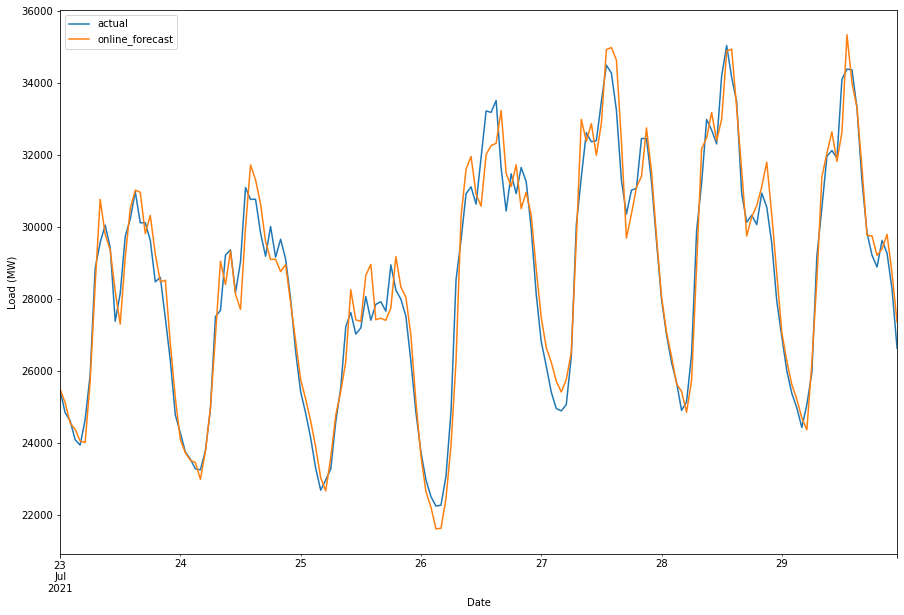

In [13]:
df_plot[['actual', 'online_forecast']][-24*7:].plot(figsize=(15,10))
plt.ylabel('Load (MW)')
plt.show()

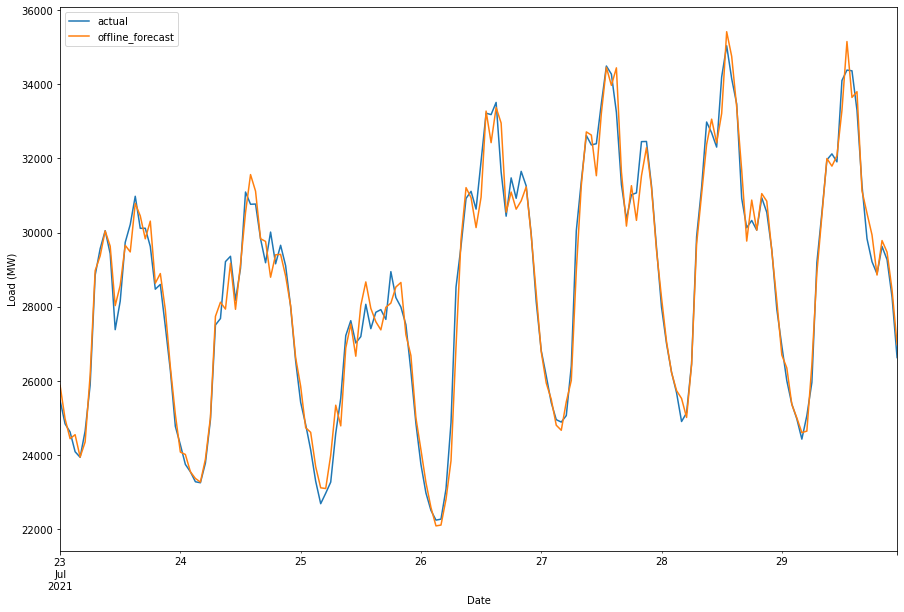

In [14]:
df_plot[['actual', 'offline_forecast']][-24*7:].plot(figsize=(15,10))
plt.ylabel('Load (MW)')
plt.show()